## This notebook illustrates unfolding using the RooUnfold methods 

In [1]:
import time
import ROOT
import numpy as np
import pandas as pd
import root_pandas as rpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from root_pandas import read_root
from matplotlib import rc
from numpy import inf

rc('text', usetex=True)

Welcome to JupyROOT 6.15/01


In [2]:
from AtlasCommonUtils import SetAtlasStyle
from Legend import Legend
from ROOT import TLatex

/mnt/c/Users/marratia/Linux/buildroot/lib/ROOT.py:579: UserWarning: "from ROOT import *" is not supported under IPython
  warnings.warn( '"from ROOT import *" is not supported under IPython' )


In [3]:
ROOT.gInterpreter.ProcessLine('#include "MyTUnfoldDensity.h"')


0L

In [4]:
def applyCut(inputDataframe, cut, text=None):
    dataframe = inputDataframe
    nbeforecut = dataframe.shape[0]
    cutDataframe = dataframe.query(cut)
    if text:
        print text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut)
    return cutDataframe

In [5]:
def getJetData(inputFiles, isMC=False):
    
    cols = []
    scalar = []
  
    scalar.append('x')
    scalar.append('y')
    scalar.append('Q2')

    scalar.append('e_eta')
    scalar.append('e_theta')
    scalar.append('e_p')
    scalar.append('e_pt')

    cols.append('jet_p')
    cols.append('jet_pt')
    cols.append('jet_qt')
    cols.append('jet_dphi')
    cols.append('jet_z')
    
    if(isMC):
        cols.append('genjet_p')
        cols.append('genjet_pt')
        cols.append('genjet_qt')
        cols.append('genjet_dphi')
        cols.append('genjet_z')

    lists = scalar
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=lists+cols,flatten=cols)
        dataframes.append(df)
        end = time.time()
        print '\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds'
    return pd.concat([x for x in dataframes])

In [6]:
def printSummary(df):
    print df['e_pt'].mean(), ' mean lepton pt'
    print df['y'].mean(), ' mean inelasticity'
    print df['jet_p'].mean(), ' mean jet p'
    print df['jet_pt'].mean(), ' mean jet pT'
    print df['jet_pt'].describe()

    print df['x'].mean(), ' mean x'
    print df['Q2'].mean(), ' mean Q2'
    print df['Q2'].describe()
    return

In [7]:
def getData(inputFiles):
    
    cols = []
    scalar = []  
    scalar.append('x')
    scalar.append('y')
    scalar.append('Q2')
    scalar.append('e_eta')
    scalar.append('e_theta')
    scalar.append('e_p')
    scalar.append('e_pt')

    
    
    lists = scalar
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=lists+cols,flatten=cols)
        dataframes.append(df)
        end = time.time()
        print '\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds'
    return pd.concat([x for x in dataframes])

In [8]:
def applyCuts(df):
    temp = df
    temp = applyCut(temp, '0.2 < y < 0.7', '0.2 < y < 0.7')
    temp = applyCut(temp, 'Q2>150', 'Q2>150')
    temp = applyCut(temp, 'e_pt>10', 'e_pt >10')
    #temp = applyCut(temp, 'x > 0.05', 'x>0.05')
    temp.eval('logQ2= log(Q2)/2.3025850', inplace=True)
    temp.eval('logx= log(x)/2.3025850', inplace=True)
    return temp

In [9]:
def applyCutsJets(df,isMC=False):
    temp = df
    temp = applyCut(temp, '0.2 < y < 0.7', '0.2 < y < 0.7')
    temp = applyCut(temp, 'Q2>150', 'Q2>150')
    temp = applyCut(temp, 'e_pt>10', 'e_pt >10')
    temp = applyCut(temp, 'jet_pt>5', 'jet_pt>5')
    #temp = applyCut(temp, 'jet_qt<5', 'jet_qt<5')

    #temp = applyCut(temp, 'dphi_e_jet > 2.74', 'dphi_e_jet>3.14159-0.4')
    #temp = applyCut(temp, 'Q2>100.0', ' Q2>100.0')
    
    #temp.eval('dphi = 3.14159-jet_dphi', inplace=True)
    temp.eval('jet_qtnormjetpt= jet_qt/jet_pt', inplace=True)
    temp.eval('jet_qtnormept= jet_qt/e_pt', inplace=True)
    if(isMC):
        temp.eval('genjet_qtnormept= genjet_qt/e_pt', inplace=True)
        temp.eval('genjet_qtnormjetpt= genjet_qt/genjet_pt', inplace=True)


    #df = applyCut(df, 'n_total>1', ' n>1')
    return temp

## Get dataframes

In [10]:
df = getData(['data.root'])
df = applyCuts(df)

mc = getData(['mc.root'])
mc = applyCuts(mc)


Processed data.root in 0.3 seconds
0.2 < y < 0.7 170849  fraction kept: 100.0
Q2>150 170849  fraction kept: 100.0
e_pt >10 137246  fraction kept: 80.3

Processed mc.root in 0.1 seconds
0.2 < y < 0.7 118567  fraction kept: 100.0
Q2>150 118567  fraction kept: 100.0
e_pt >10 97889  fraction kept: 82.6


In [11]:
df_jet      = getJetData(['data.root'])
df_jet = applyCutsJets(df_jet)

mc_jet = getJetData(['mc.root'],isMC=True)
mc_jet = applyCutsJets(mc_jet, isMC=True)


Processed data.root in 2.5 seconds
0.2 < y < 0.7 82882  fraction kept: 100.0
Q2>150 82882  fraction kept: 100.0
e_pt >10 70103  fraction kept: 84.6
jet_pt>5 70103  fraction kept: 100.0

Processed mc.root in 3.4 seconds
0.2 < y < 0.7 145313  fraction kept: 100.0
Q2>150 145313  fraction kept: 100.0
e_pt >10 125072  fraction kept: 86.1
jet_pt>5 125072  fraction kept: 100.0


## define variables, binning, etc

In [176]:
#coarsebins = 15
#finebins = 15
#minval = 2.5
#maxval = np.pi
#variable    = 'jet_dphi' 
#genvariable = 'genjet_dphi'
#namevariable = r'$\Delta\phi$'

#coarsebins = 7
#finebins = 7
#minval = 0.0
#maxval = 10
#variable = 'jet_qt'
#genvariable = 'genjet_qt'
#namevariable = r'$q_{T}'

#minval = 0.0 
#maxval = 1.0
#variable = 'jet_qtnormept'
#genvariable = 'genjet_qtnormept'


coarsebins = 8
finebins = 8
minval = 0.0
maxval = 0.50
variable = 'jet_qtnormjetpt'
genvariable = 'genjet_qtnormjetpt'
namevariable = r'$q_{T}/p_{T}^{jet}$'

#coarsebins = 10
#finebins = 10
#minval = 0
#maxval = 1.0
#variable = 'jet_z'
#genvariable = 'genjet_z'
#namevariable = r'$z_{jet}$'


binwidth = (maxval - minval)/coarsebins

M = ROOT.TH2D("M", "Response Matrix", coarsebins,minval,maxval, finebins,minval,maxval)
M1 = M.Clone("M1")
M2 = M.Clone("M2")
M1.SetTitle("+1#sigma")
M2.SetTitle("-1#sigma")

scaleup = 1.001
scaledn = 0.999

eptmin = 20
eptmax = 25

Warning in <TROOT::Append>: Replacing existing TH1: M (Potential memory leak).


## make data selection, split MC in two statistically independent samples

In [177]:
data_cut = df_jet.query('e_pt > %2.2f and e_pt<%2.2f'%(eptmin,eptmax))
mc_cut = mc_jet.query('e_pt > %2.2f and e_pt<%2.2f'%(eptmin,eptmax))
print len(mc_cut)
msk = np.random.rand(len(mc_cut)) < 0.25
mctest_cut = mc_cut[msk]
mc_cut   = mc_cut[~msk]
print len(mctest_cut)
print len(mc_cut)

12505
3153
9352


<function matplotlib.pyplot.hist>

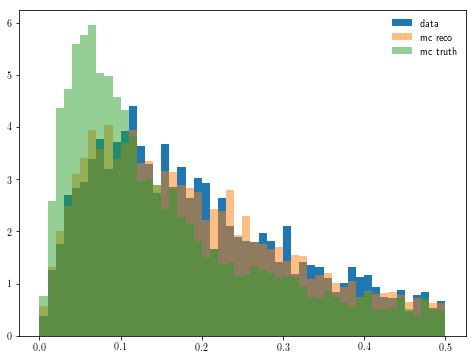

In [178]:
fig = plt.figure(figsize=(8,6))

plt.hist(data_cut[variable],range=(0,maxval),bins=50,normed=True,label='data')
plt.hist(mc_cut[variable],range=(0,maxval),bins=50,normed=True,alpha=0.5,label='mc reco')
plt.hist(mc_cut[genvariable],range=(0,maxval),bins=50, normed=True,alpha=0.5,label =' mc truth')
plt.legend(loc='best', frameon=False)
plt.hist

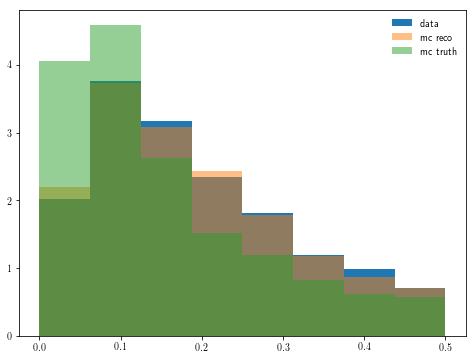

In [179]:
fig = plt.figure(figsize=(8,6))

plt.hist(data_cut[variable],range=(0,maxval),bins=coarsebins,normed=True,label='data')
plt.hist(mc_cut[variable],range=(0,maxval),bins=coarsebins,normed=True,alpha=0.5,label='mc reco')
plt.hist(mc_cut[genvariable],range=(0,maxval),bins=coarsebins, normed=True,alpha=0.5,label =' mc truth')
plt.legend(loc='best', frameon=False)


## Fill response matrix

In [180]:
Npe = len(mc_cut[variable])

for i in np.arange(len(mc_cut[variable])):
    x = mc_cut.iloc[i][variable]
    y = mc_cut.iloc[i][genvariable]
    M.Fill(x, y, 1./Npe)
#
#plt.hist(df_cut['jet_qt'],bins=10,range=(0,10.0),normed=True,alpha=0.9, label='MC reco',histtype='step',lw=2)


## Plot response matrix

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c0


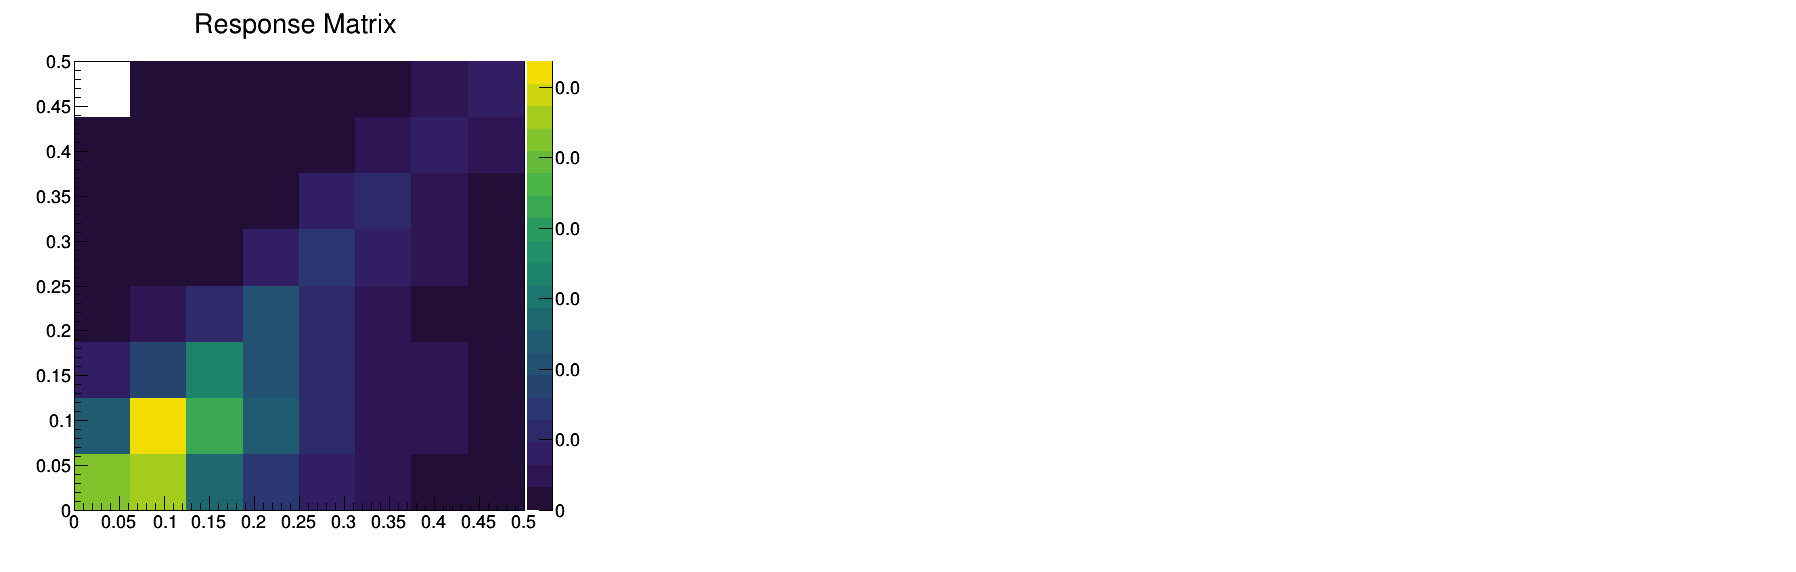

In [181]:
ROOT.gStyle.SetOptStat("")
ROOT.gStyle.SetPalette(ROOT.kViridis);
ROOT.gStyle.SetTitleYOffset(0.85)
ROOT.gStyle.SetEndErrorSize(10)


c0 = ROOT.TCanvas("c0", "c0", 1800, 600)
c0.Divide(3,1)
c0.cd(1)
M.Draw("colz")
c0.Draw()

## fill mc truth and mc reco histograms

In [182]:
h_mcreco = ROOT.TH1D("h_mcreco", "h_mcreco", finebins, minval, maxval)
h_mctrue = ROOT.TH1D("h_mctrue", "h_mctrue", finebins, minval, maxval)
   
for i in np.arange(len(mc_cut[variable])):
    h_mctrue.Fill(mc_cut.iloc[i][genvariable])
    h_mcreco.Fill(mc_cut.iloc[i][variable])


Warning in <TROOT::Append>: Replacing existing TH1: h_mcreco (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_mctrue (Potential memory leak).


## Create data histogram and pseudodata histogram 

In [183]:
h_fakedata = ROOT.TH1D("h_fakedata", "h_fakedata", finebins, minval, maxval)   
    
for i in np.arange(len(mctest_cut[variable])):
    h_fakedata.Fill(mctest_cut.iloc[i][variable])
       
h_data = ROOT.TH1D("h_data", "h_data", finebins, minval, maxval)   
for i in np.arange(len(data_cut[variable])):
    h_data.Fill(data_cut.iloc[i][variable])

Warning in <TROOT::Append>: Replacing existing TH1: h_fakedata (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_fakedata (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_data (Potential memory leak).


## Plot mc truth, mc reco, data, and pseudodata

Warning in <TCanvas::Constructor>: Deleting canvas with same name: creco


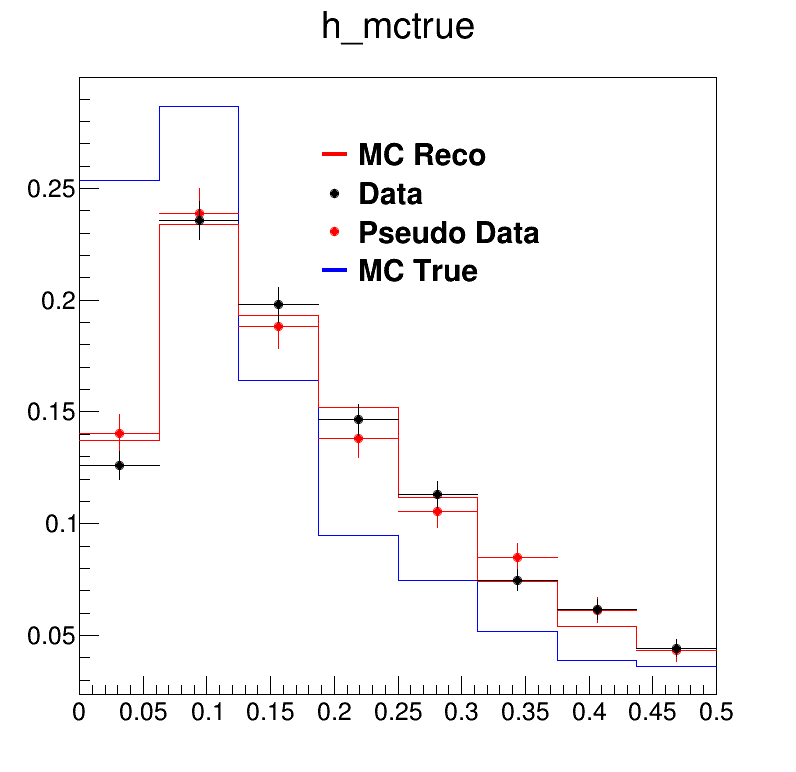

In [184]:
#h_mcreco.SetMarkerStyle(20)
h_data.SetMarkerStyle(20)
h_data.SetMarkerColor(ROOT.kBlack)
h_data.SetLineColor(ROOT.kBlack)

#h_mctrue.SetMarkerStyle(21)
h_fakedata.SetMarkerColor(ROOT.kRed)
h_fakedata.SetLineColor(ROOT.kRed)

h_fakedata.SetLineWidth(1)

h_fakedata.SetMarkerStyle(20)
h_mctrue.SetLineColor(ROOT.kBlue)
h_mcreco.SetLineColor(ROOT.kRed)
#h_fakedata.SetLineColor(ROOT.kBlue)
#h_mctrue.SetLineColor(ROOT.kRed)

creco = ROOT.TCanvas("creco", "creco", 800, 800)
h_mctrue.DrawNormalized()
h_mctrue.SetMinimum(0.0)
h_mcreco.DrawNormalized('same')
h_fakedata.DrawNormalized("e same")
h_data.DrawNormalized("e same")

creco.Draw()

ROOT.gStyle.SetOptStat("")


label = Legend("")
label.Add( h_mcreco, 'MC Reco', 'L')
label.Add(h_data, 'Data','P')
label.Add(h_fakedata, 'Pseudo Data', 'P')
label.Add( h_mctrue, 'MC True', 'L')
label.Draw(.4,.85)


## Load modules needed for the unfolding

In [185]:
ROOT.gSystem.Load("/mnt/c/Users/marratia/Linux/RooUnfold/libRooUnfold")
from ROOT import gRandom, TH1, TH1D, TH2D, cout, THStack
#for unfolding
from ROOT import RooUnfoldResponse
from ROOT import RooUnfold
from ROOT import RooUnfoldBayes
from ROOT import RooUnfoldSvd
from ROOT import RooUnfoldTUnfold
from ROOT import RooUnfoldBinByBin
from ROOT import RooUnfoldIds

from AtlasCommonUtils import SetAtlasStyle
from Legend import Legend
from ROOT import TLatex

## Plot response matrix and projections

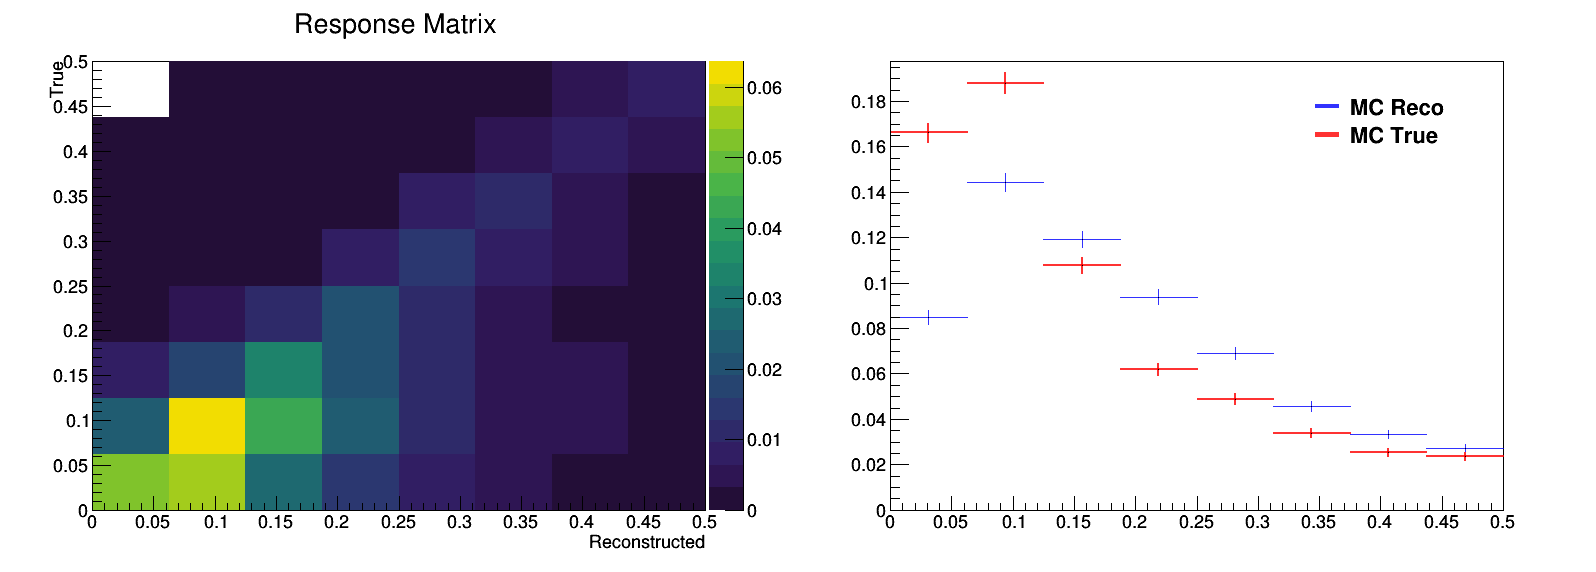

In [186]:
responseMatrix = M
mc_truth = responseMatrix.ProjectionY()
mc_reco = responseMatrix.ProjectionX()
mc_truth.SetLineColorAlpha(2,0.8)
mc_reco.SetLineColorAlpha(4,0.8)

##draw mc truth, mc reco, response matrix
c = ROOT.TCanvas('c','c',1600,600)
c.Divide(2)
c.cd(1)
responseMatrix.Draw('colz')
responseMatrix.SetTitle('Response Matrix; Reconstructed; True')

#ROOT.gPad.SetLogz()
c.cd(2)


label = Legend("")
label.Add(mc_reco,'MC Reco','L')
label.Add(mc_truth,'MC True','L')

hs_mc = ROOT.THStack()
hs_mc.Add(mc_reco)
hs_mc.Add(mc_truth)
hs_mc.Draw('nostack')
#hs_mc.SetTitle(axestitle[variable])

label.Draw(0.65,.87)
c.Draw()

# Define input for unfolding, create dictionaries to store results

In [187]:
data_inputforunfolding = h_data.Clone()
#data_inputforunfolding = h_fakedata.Clone()

response= RooUnfoldResponse(mc_reco, mc_truth, responseMatrix,"response","response")
#response.UseOverflow()

data_unfolded = {}
Covariance = {}
InverseCovariance  = {}
correlation = {}
unfold = {}

# Find appropiate number of iterations for the Bayesian Unfolding

In [188]:
## Computes the global correlation coefficient
def get_averagerho(cov,inversecov):
    nrows= cov.GetNrows()
    ncolumns = cov.GetNcols()
    rhos = []
    for i in range(nrows) :
        #print np.sqrt(1- 1.0/(cov(i,i)*inversecov(i,i)))
        if(cov(i,i)*inversecov(i,i)!=0):
            rhos.append( np.sqrt(1- 1.0/(cov(i,i)*inversecov(i,i))))
        else:
            print 'something messed up with the inverse cov or cov'
    #print rhos
    return np.average(rhos)


def GetCorrelationMatrix ( cov, name):

    nrows= cov.GetNrows()
    ncolumns = cov.GetNcols()
    
    h= ROOT.TH2D (name, "", nrows, 0, nrows, ncolumns, 0, ncolumns);
    h.SetAxisRange (-1.0, 1.0, "Z")
    for i in range(nrows) :
        for j in range(ncolumns) :
            Viijj= cov(i,i)*cov(j,j)
            if Viijj>0.0: h.SetBinContent (i+1, j+1, cov(i,j)/ROOT.TMath.Sqrt(Viijj))
            
    return h

## Do check convergence of iterative unfolding procedure. Check Correlation matrices and the unfolded result. We expect the correlation matrix to show **negative** correlation between adjacent bins. If we see too much large positive correlations, it means that the unfolding has not converged yet. 

In [189]:
c = ROOT.TCanvas('c','c',1600,1600)
c.Divide(4,8)
for i in range(1,120):
    unfold['Bayes_iter%i'%i] = RooUnfoldBayes(response, data_inputforunfolding, i)
    h = unfold['Bayes_iter%i'%i].Hreco();
    Covariance['Bayes_iter%i'%i] = unfold['Bayes_iter%i'%i].Ereco();
    InverseCovariance['Bayes_iter%i'%i] = unfold['Bayes_iter%i'%i].Wreco();
    correlation['Bayes_iter%i'%i] = GetCorrelationMatrix(Covariance['Bayes_iter%i'%i], 'Bayes_iter%i'%i)
    
    #c.cd(i-2)#i-2
    #h.Scale(1.0/h.Integral())
    #h.Draw()
    #h.SetLineColor(i)
    
#c.Draw()

Now unfolding...
Iteration : 0
Chi^2 of change 2.98136
Calculating covariances due to number of measured events
covariance matrix condition=426, determinant=7.63824e+10, tolerance=2.22045e-16
Inverse covariance matrix 2.11046e-12% maximum error
Now unfolding...
Iteration : 0
Chi^2 of change 2.98136
Iteration : 1
Chi^2 of change 1.17282
Calculating covariances due to number of measured events
covariance matrix condition=120.627, determinant=7.67437e+14, tolerance=2.22045e-16
Inverse covariance matrix 5.06496e-13% maximum error
Now unfolding...
Iteration : 0
Chi^2 of change 2.98136
Iteration : 1
Chi^2 of change 1.17282
Iteration : 2
Chi^2 of change 0.480407
Calculating covariances due to number of measured events
covariance matrix condition=62.8693, determinant=1.23271e+17, tolerance=2.22045e-16
Inverse covariance matrix 2.17664e-13% maximum error
Now unfolding...
Iteration : 0
Chi^2 of change 2.98136
Iteration : 1
Chi^2 of change 1.17282
Iteration : 2
Chi^2 of change 0.480407
Iteration 

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


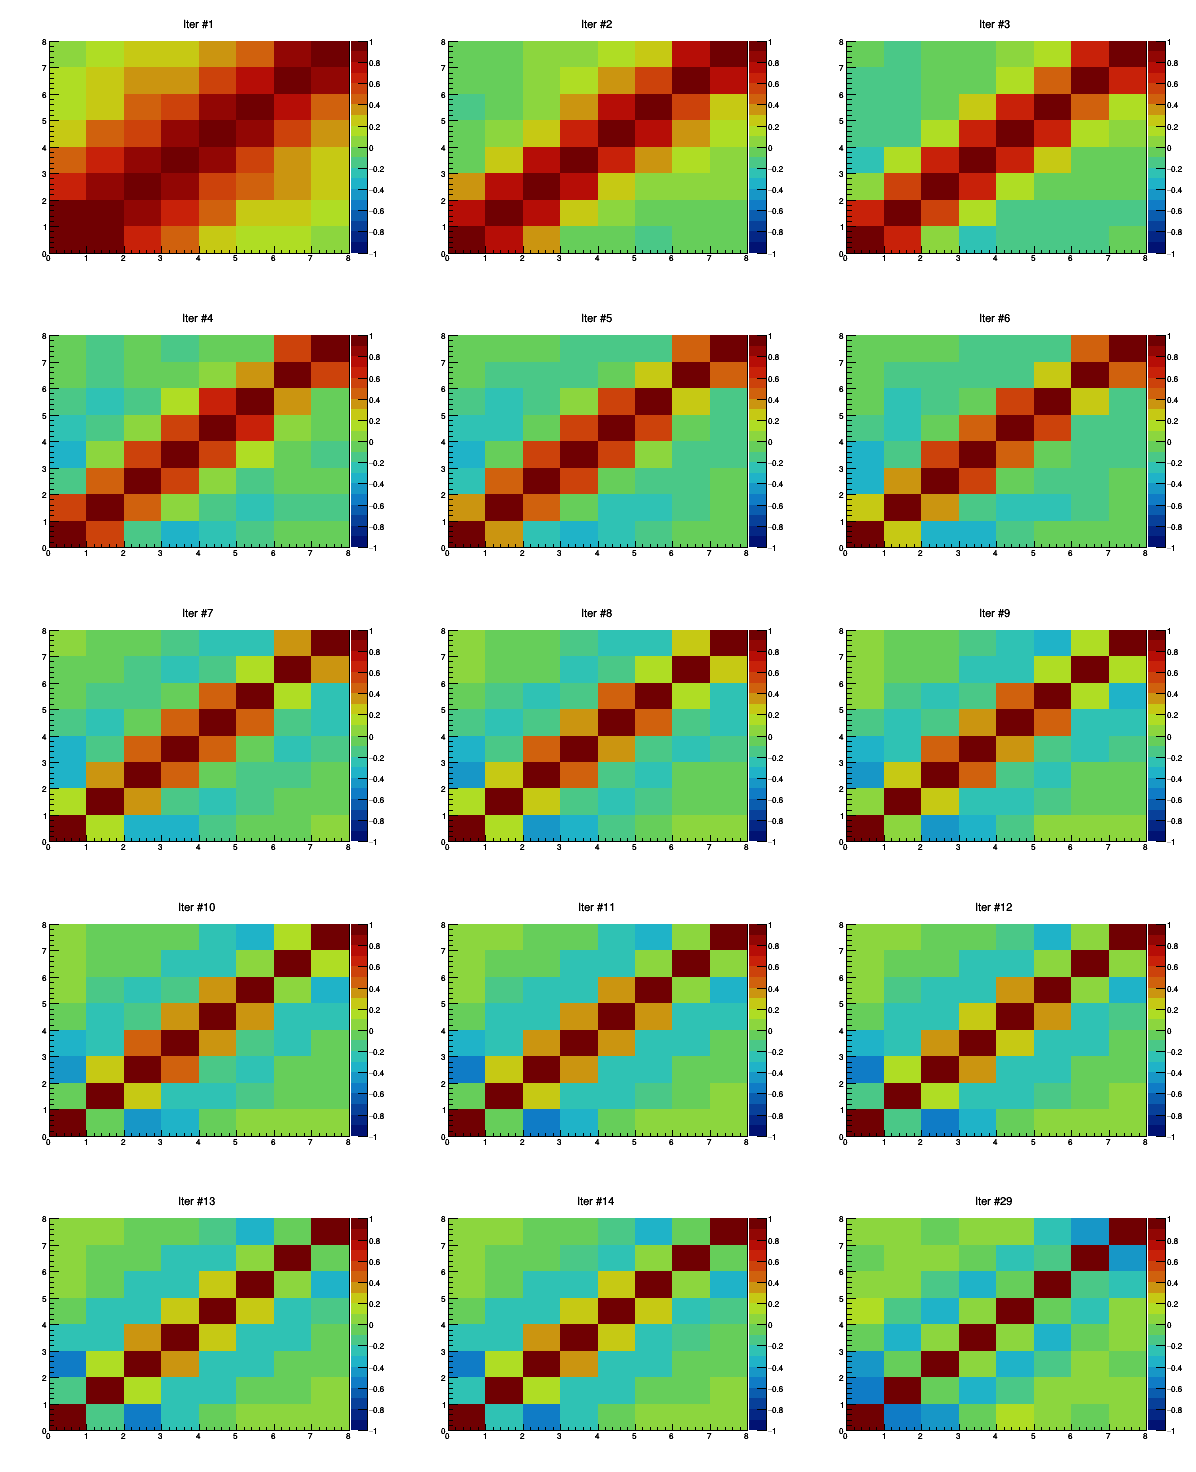

In [190]:
c = ROOT.TCanvas('c','c',1200,1500)
c.Divide(3,5)
ROOT.gStyle.SetPalette(ROOT.kRainBow);

rho = []
iteration = []
for i in range(1,30):
    c.cd(i)
    correlation['Bayes_iter%i'%i].SetTitle('Iter #%i'%i)
    correlation['Bayes_iter%i'%i].Draw('colz')
    rho.append(get_averagerho(Covariance['Bayes_iter%i'%i],InverseCovariance['Bayes_iter%i'%i]))
    iteration.append(i)
#print rho
c.Draw()

## Average global correlation coefficient vs number of iterations
## the global correlation coefficient for bin i is defined as
## rho_i = sqrt[ 1 - 1/(Cov_ii*InverseCov_ii)]
## Take average of all rho_i and stsudy dependence of the number of iterations. Should take the minimum.

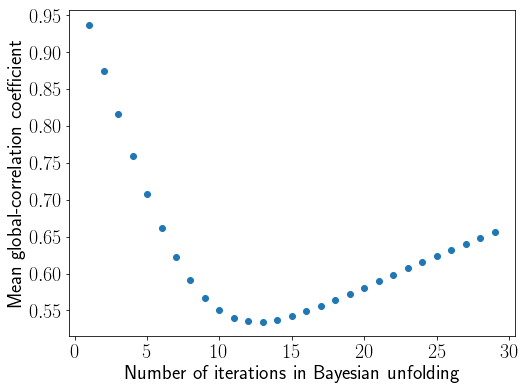

The number of iterations that results in the minimum average global correlation coefficient is 12
The minimum average global correlation coefficient is 0.53


In [191]:
fig = plt.figure(figsize=(8,6))
plt.plot(iteration,rho,'o')
plt.xlabel('Number of iterations in Bayesian unfolding',fontsize=20)
plt.ylabel('Mean global-correlation coefficient',fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.show()
print 'The number of iterations that results in the minimum average global correlation coefficient is', np.argmin(rho)
print 'The minimum average global correlation coefficient is %2.2f'%min(rho)

nbayes_iter = np.argmin(rho)


## Perform unfolding with optimal number of iterations (found above)

In [192]:


unfold['Bayes'] = RooUnfoldBayes(response, data_inputforunfolding, nbayes_iter)
#RooUnfoldTUnfold(response, data_inputforunfolding) # 
unfold['Bayes'].IncludeSystematics()


data_unfolded['Bayes'] = unfold['Bayes'].Hreco()
Covariance['Bayes'] = unfold['Bayes'].Ereco();
unfold['Bayes'].PrintTable (cout, mc_truth)


Now unfolding...
Iteration : 0
Chi^2 of change 2.98136
Iteration : 1
Chi^2 of change 1.17282
Iteration : 2
Chi^2 of change 0.480407
Iteration : 3
Chi^2 of change 0.223427
Iteration : 4
Chi^2 of change 0.125003
Iteration : 5
Chi^2 of change 0.0835774
Iteration : 6
Chi^2 of change 0.063402
Iteration : 7
Chi^2 of change 0.0518614
Iteration : 8
Chi^2 of change 0.0443063
Iteration : 9
Chi^2 of change 0.038872
Iteration : 10
Chi^2 of change 0.034716
Iteration : 11
Chi^2 of change 0.0314043
Calculating covariances due to number of measured events
Calculating covariance due to unfolding matrix...
covariance matrix condition=12.1563, determinant=1.14236e+25, tolerance=2.22045e-16
Inverse covariance matrix 1.41727e-13% maximum error
         Train    Train     Test     Test Unfolded  Error on     Diff     Pull
  Bin    Truth Measured    Truth    Input   Output Unfolding
    1        0        0        0      401    774.5      59.1    774.4     13.1
    2        0        0        0      750   1006

## Error matrix

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


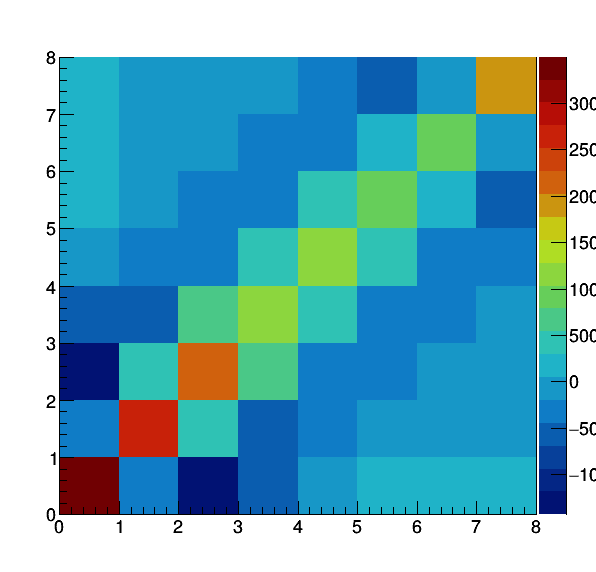

In [193]:
c = ROOT.TCanvas('c','c',600,600)
Covariance['Bayes'].Draw("colz")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


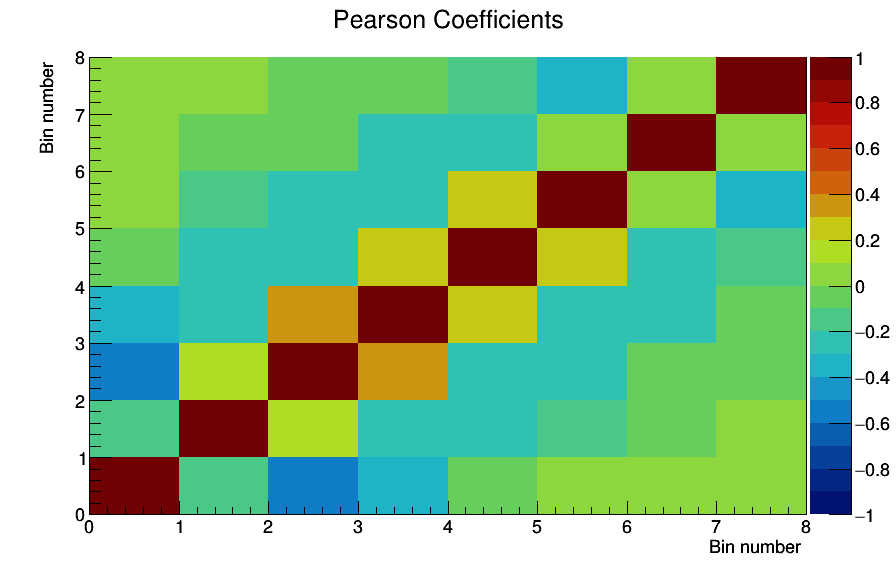

In [194]:
ROOT.gStyle.SetPalette(ROOT.kRainBow);

c = ROOT.TCanvas('c','c',900,600)
correlation = {}

correlation['Bayes'] = GetCorrelationMatrix(Covariance['Bayes'], 'Bayes')
correlation['Bayes'].Draw('colz')
#correlation['Bayes'].GetXaxis().SetRangeUser(1,7)
#correlation['Bayes'].GetYaxis().SetRangeUser(1,7)
correlation['Bayes'].GetXaxis().SetTitle('Bin number')
correlation['Bayes'].GetYaxis().SetTitle('Bin number')
correlation['Bayes'].SetTitle('Pearson Coefficients')

c.Draw()

## Compare data after unfolded, data at reconstructed level, and MC truth

Bayes   1   0.03125  0.223  0.017
Bayes   2   0.09375  0.289  0.015
Bayes   3   0.15625  0.168  0.013
Bayes   4   0.21875  0.087  0.010
Bayes   5   0.28125  0.073  0.009
Bayes   6   0.34375  0.053  0.009
Bayes   7   0.40625  0.053  0.009
Bayes   8   0.46875  0.052  0.012
[0.03125 0.09375 0.15625 0.21875 0.28125 0.34375 0.40625 0.46875]
[0.22283533 0.2894766  0.16792702 0.0874347  0.07334768 0.05309658
 0.05338533 0.05249677]
[0.01701002 0.01467471 0.01339928 0.01004978 0.00946154 0.00916976
 0.00907386 0.01225581]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


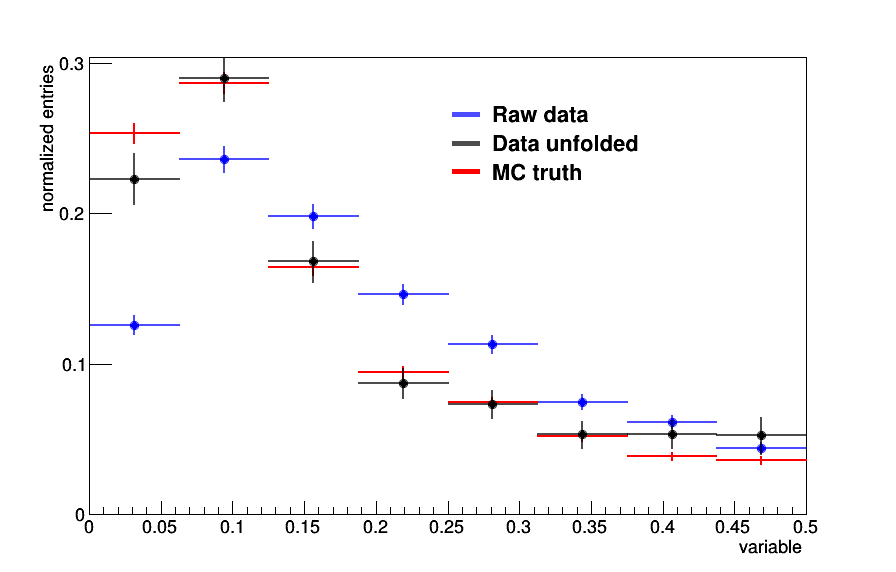

In [195]:
c = ROOT.TCanvas('c','c',900,600)

label = Legend("")
alpha = 0.7
hstack = ROOT.THStack()
h_data.SetLineWidth(2)
h_data.SetLineColorAlpha(4,alpha)
h_data.SetMarkerColor(4)
mc_truth.SetLineColor(2)
mc_truth.SetLineWidth(2)
mc_truth.SetMarkerColor(2)

h_data.SetMarkerStyle(20)

color = {}
color['Bayes'] = 1

h_data.Scale(1.0/h_data.Integral())
mc_truth.Scale(1.0/mc_truth.Integral())


result_x = np.array([])
result_y = np.array([])
result_erry = np.array([])

for key in ['Bayes']:
    data_unfolded[key].SetMarkerStyle(20)
    data_unfolded[key].SetLineWidth(2)
    data_unfolded[key].SetLineColorAlpha(color[key],alpha)
    data_unfolded[key].SetMarkerColor(color[key])
    data_unfolded[key].Scale(1.0/data_unfolded[key].Integral())

    for i in range(1,data_unfolded[key].GetNbinsX()+1):
        print key, ' ' , i , ' ', data_unfolded[key].GetBinCenter(i), ' %2.3f'%data_unfolded[key].GetBinContent(i), ' %2.3f'%data_unfolded[key].GetBinError(i)
        result_x = np.append(result_x, data_unfolded[key].GetBinCenter(i))
        result_y = np.append(result_y, data_unfolded[key].GetBinContent(i))
        result_erry = np.append(result_erry, data_unfolded[key].GetBinError(i))
hstack.Add(h_data)
hstack.Add(mc_truth)
hstack.Add(data_unfolded['Bayes'])
label.Add(h_data, 'Raw data', 'L')
label.Add(data_unfolded['Bayes'],'Data unfolded','L')      
label.Add(mc_truth, 'MC truth', 'L')

hstack.SetTitle('; variable; normalized entries')
hstack.Draw('nostack')
hstack.GetYaxis().SetNdivisions(6)
label.Draw(.5,.85)

c.Draw()
print result_x
print result_y
print result_erry
#c.SaveAs('Unfoldedresult%s.pdf'%(datatype))

## Closure test: feed pseudodata (MC) to the unfolding and test whether it is compatible with the truth distribution

In [196]:
#data_inputforunfolding = h_data.Clone()
data_inputforunfolding = h_fakedata.Clone()

response= RooUnfoldResponse(mc_reco, mc_truth, responseMatrix,"response","response")
#response.UseOverflow()

closure = RooUnfoldBayes(response, data_inputforunfolding, nbayes_iter).Hreco();


Now unfolding...
Iteration : 0
Chi^2 of change 2.86159
Iteration : 1
Chi^2 of change 1.33103
Iteration : 2
Chi^2 of change 0.680538
Iteration : 3
Chi^2 of change 0.399708
Iteration : 4
Chi^2 of change 0.266951
Iteration : 5
Chi^2 of change 0.195283
Iteration : 6
Chi^2 of change 0.151245
Iteration : 7
Chi^2 of change 0.121391
Iteration : 8
Chi^2 of change 0.0997849
Iteration : 9
Chi^2 of change 0.0834593
Iteration : 10
Chi^2 of change 0.070749
Iteration : 11
Chi^2 of change 0.0606289
Calculating covariances due to number of measured events


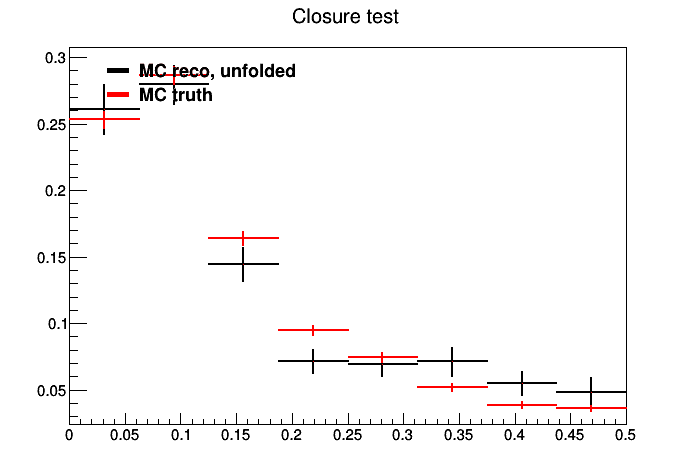

In [197]:
c = ROOT.TCanvas()
closure.SetLineColor(1)
closure.SetMarkerColor(2)
closure.Scale(1/closure.Integral())
closure.SetTitle('Closure test')
closure.Draw()
mc_truth.Draw('same')
label = Legend("")
label.Add(closure, 'MC reco, unfolded', 'L')
label.Add(mc_truth, 'MC truth' ,     'L')
label.Draw(.15,.90)

c.Draw()

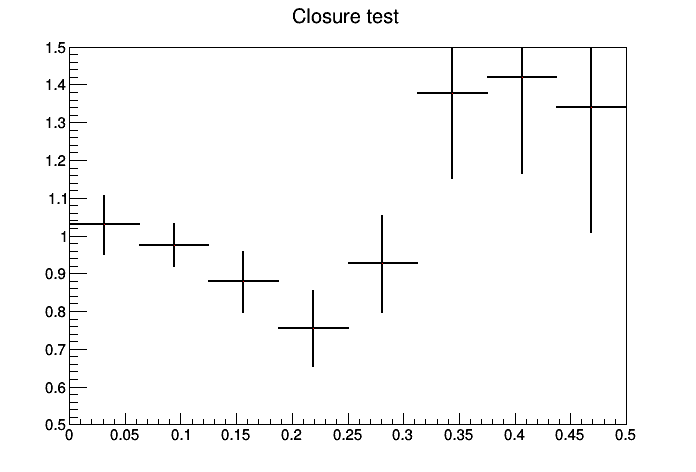

In [198]:
temp = closure.Clone('temp')
temp.Divide(mc_truth)
c = ROOT.TCanvas()
temp.Draw()
temp.SetMinimum(0.5)
temp.SetMaximum(1.5)
temp.SetTitle('Closure test')
c.Draw()

## Multiply the unfolded result by the response matrix, compare with data. This is the "refolded check"

In [199]:
def Refold ( response, unfolded):
    nrows= response.GetNbinsX()-1
    ncolumns = response.GetNbinsX()-1
    h= unfolded.Clone('refolded')
    for i in range(nrows) :
        temp = 0.0
        for j in range(ncolumns) :
            temp = temp + response.GetBinContent (i+1, j+1)*unfolded.GetBinContent(j+1)
        h.SetBinContent(i+1, temp)
    return h

In [200]:
print type(response)

<class 'ROOT.RooUnfoldResponse'>


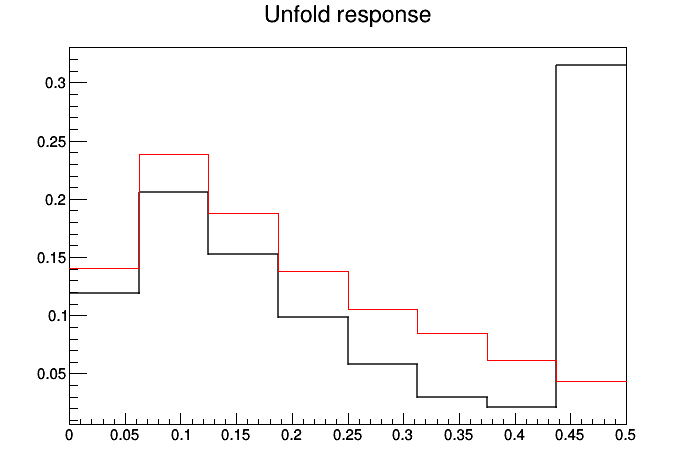

In [201]:
refolded = Refold(responseMatrix,data_unfolded['Bayes'])
c = ROOT.TCanvas()
refolded.DrawNormalized('hist')
#data_unfolded['Bayes'].DrawNormalized('same')
data_inputforunfolding.DrawNormalized('same')
c.Draw()

## Plot Final, unfolded result vs MC truth

22.189854  mean lepton pt
0.3740579  mean inelasticity
27.507795  mean jet p
18.459114  mean jet pT
count    12505.000000
mean        18.459114
std          7.225825
min          5.007350
25%         13.152508
50%         19.432480
75%         23.391794
max         49.159706
Name: jet_pt, dtype: float64
0.022796264  mean x
833.8505  mean Q2
count    12505.000000
mean       833.850525
std        246.688538
min        500.800629
25%        657.330872
50%        772.001404
75%        936.399475
max       2028.920044
Name: Q2, dtype: float64
###########


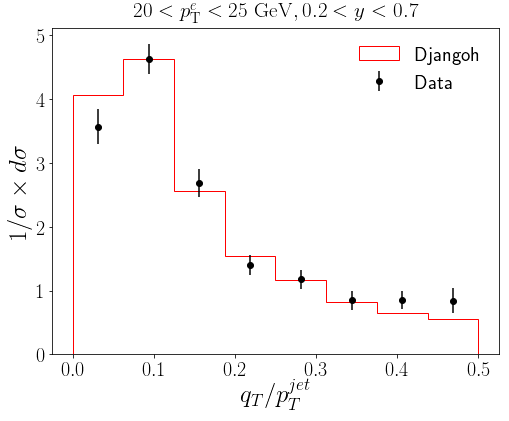

In [202]:
rc('text', usetex=True)


fig = plt.figure(figsize=(8,6))


df_cut = mc_jet.query('e_pt > %2.2f and e_pt<%2.2f'%(eptmin,eptmax))
printSummary(df_cut)
print '###########'
    
plt.hist(df_cut[genvariable],bins=coarsebins,range=(minval,maxval),normed=True,histtype='step',color='red',label='Djangoh')    
plt.errorbar(x=result_x,y=np.divide(result_y,binwidth), yerr=np.divide(result_erry,binwidth), fmt='o',ls='none',label='Data',color='black')

plt.xlabel(namevariable, fontsize=25)
plt.ylabel(r'$1/\sigma \times d\sigma$ ', fontsize=25)
#plt.tick_params('both',labelsize=20)

plt.title(r' $ %2.0f< p_{\mathrm{T}}^{e} < %2.0f \mathrm{~GeV}, 0.2<y<0.7$'%(eptmin,eptmax),fontsize=21)
#plt.text(0.05,1.2, r' $ %2.0f< p_{\mathrm{T}}^{e} < %2.0f$'%(eptmin,eptmax) + '$\ \mathrm{ GeV}$ \n' +
#                      r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(df_cut['x'].mean(), df_cut['Q2'].mean()), fontsize=21)

plt.legend(loc='best',frameon=False)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.legend(prop={'size': 20}, frameon=False, loc='best')
#plt.legend(loc='best',frameon=False)
plt.savefig('qtplot.png', bbox_inches='tight')
plt.savefig('qtplot.pdf', bbox_inches='tight')